In [ ]:
# Setup and Data Loading

import jax
from furax_cs import (
    load_cmb_map,
    save_cmb_map,
    save_to_cache,
)

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Configure JAX
jax.config.update("jax_enable_x64", True)

r_tensor_to_scalar_ratio = 4
# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2
noise_id = 0
noise_ratio = 1.0
tag = f"cr{r_tensor_to_scalar_ratio}d0s0"
mask_name = "ALL"

In [7]:
# Generate and load CMB data
!rm -rf freq_maps_cache/
save_to_cache(nside, sky=tag)
save_cmb_map(nside, sky=tag)
cmb_map = load_cmb_map(nside, sky=tag)
print(f"CMB map shape: {cmb_map.shape}")

/home/wassim/micromamba/envs/fg/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[INFO] Detected custom r tag: cr4
[INFO] Generating custom CMB with r=0.004
[INFO] generating with r_value 0.004


/home/wassim/Projects/CMB/furax-compsep-paper/src/furax_cs/data/instruments.py:41: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return FGBusterInstrument(frequency, depth_i, depth_p)


[INFO] Added custom CMB with r=0.004 to maps.
✓ Generated and saved freq_maps for nside 64.
[INFO] Generating CMB map for nside 64, sky cr4d0s0
[INFO] generating with r_value 0.004
✓ Generated and saved freq_maps for nside 64 and for tag cr4.
[INFO] Loaded freq_maps for nside 64 from cache.
CMB map shape: (3, 49152)


Input r = 0.003, Estimated r = 0.003373 +0.000280 -0.000260


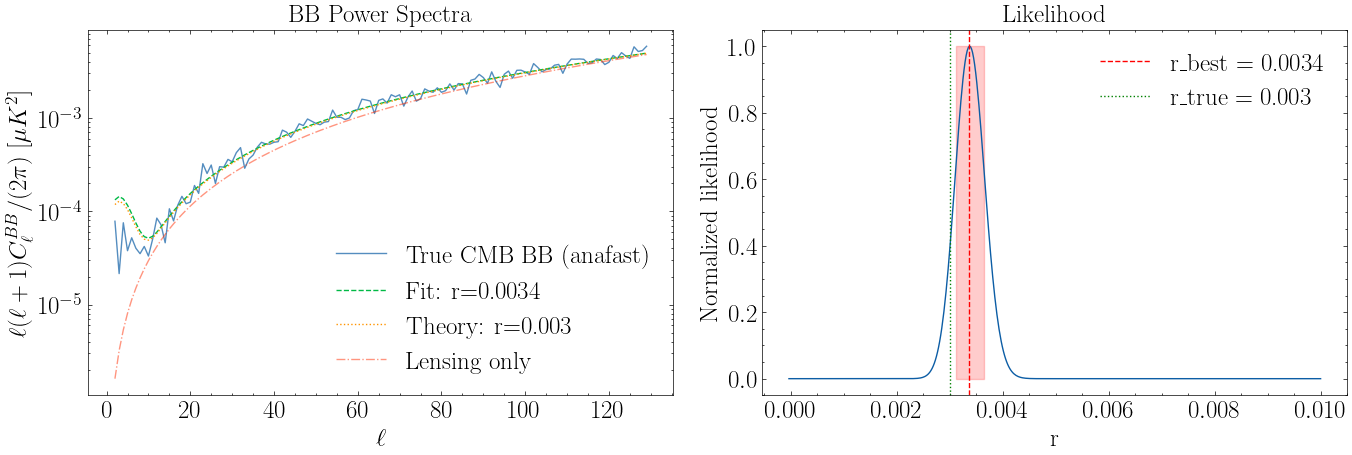

In [8]:
# Direct r estimation on true CMB (no component separation)
# This isolates whether the problem is in r estimation or in comp-sep residuals

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from furax_cs.r_analysis.r_estimate import _get_camb_templates, estimate_r

# 1. Compute BB spectrum of true CMB
cmb_iqu = np.array([cmb_map[0], np.array(cmb_map[1]), np.array(cmb_map[2])])
cl_all = hp.anafast(cmb_iqu)
ell_range, cl_bb_r1, cl_bb_lens = _get_camb_templates(nside)
cl_bb_true = cl_all[2][ell_range]  # BB component

# 2. Estimate r directly (no noise, fullsky)
r_best, sigma_neg, sigma_pos, r_grid, L_vals, _, _, _, cl_obs = estimate_r(
    cl_bb_true,
    nside,
    cl_noise=np.zeros_like(ell_range, dtype=float),
    f_sky=1.0,
    is_cl_obs=True,
    max_point=0.01,
)
print(f"Input r = 0.003, Estimated r = {r_best:.6f} +{sigma_pos:.6f} -{sigma_neg:.6f}")

# 3. Plot spectra comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: spectra
ax = axes[0]
ax.plot(
    ell_range,
    ell_range * (ell_range + 1) * cl_bb_true / (2 * np.pi),
    label="True CMB BB (anafast)",
    alpha=0.7,
)
ax.plot(
    ell_range,
    ell_range * (ell_range + 1) * (r_best * cl_bb_r1 + cl_bb_lens) / (2 * np.pi),
    label=f"Fit: r={r_best:.4f}",
    ls="--",
)
ax.plot(
    ell_range,
    ell_range * (ell_range + 1) * (0.003 * cl_bb_r1 + cl_bb_lens) / (2 * np.pi),
    label="Theory: r=0.003",
    ls=":",
)
ax.plot(
    ell_range,
    ell_range * (ell_range + 1) * cl_bb_lens / (2 * np.pi),
    label="Lensing only",
    ls="-.",
    alpha=0.5,
)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\ell(\ell+1)C_\ell^{BB}/(2\pi)$ [$\mu K^2$]")
ax.set_title("BB Power Spectra")
ax.legend()
ax.set_yscale("log")

# Right: likelihood
ax = axes[1]
ax.plot(r_grid, L_vals / L_vals.max())
ax.axvline(r_best, color="r", ls="--", label=f"r_best = {r_best:.4f}")
ax.axvline(0.003, color="g", ls=":", label="r_true = 0.003")
ax.fill_betweenx([0, 1], r_best - sigma_neg, r_best + sigma_pos, alpha=0.2, color="r")
ax.set_xlabel("r")
ax.set_ylabel("Normalized likelihood")
ax.set_title("Likelihood")
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Control test: r=0 should give r_best close to 0
save_cmb_map(nside, sky="c1d0s0")
cmb_map_r0 = load_cmb_map(nside, sky="c1d0s0")
cmb_iqu_r0 = np.array([np.zeros(12 * nside**2), np.array(cmb_map_r0[1]), np.array(cmb_map_r0[2])])
cl_bb_r0 = hp.anafast(cmb_iqu_r0)[2][ell_range]

r_best_0, sn, sp, rg, Lv, _, _, _, _ = estimate_r(
    cl_bb_r0, nside, np.zeros_like(ell_range, dtype=float), 1.0, is_cl_obs=True, max_point=0.01
)
print(f"Input r = 0, Estimated r = {r_best_0:.6f} +{sp:.6f} -{sn:.6f}")

[INFO] Generating CMB map for nside 64, sky c1d0s0
✓ Generated and saved freq_maps for nside 64 and for tag c1.
[INFO] Loaded freq_maps for nside 64 from cache.
Input r = 0, Estimated r = -0.000030 +0.000020 -0.000000
